# Import Libraries and Load Sample Data

In [13]:
import arviz as az
import numpy as np
import pandas as pd
from lifetimes import BetaGeoBetaBinomFitter

import pymc as pm
import xarray as xr

from pymc_marketing.clv import BetaGeoBetaBinomModel
from pymc_marketing.clv.distributions import BetaGeoBetaBinom
from pymc_marketing.prior import Prior

In [2]:
bgbb_donations = pd.read_csv("https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/bgbb_donations.csv")
bgbb_donations.head()

,customer_id,frequency,recency,T
0,0,0,0,6
1,1,0,0,6
2,2,0,0,6
3,3,0,0,6
4,4,0,0,6


### `BetaGeoBetaBinomModel` Testing
Sampling with `HalfFlat` priors takes 13 minutes with `nutpie`, compared to over 40 with default NUTS sampler.
Because this is a discrete time model, `nutpie` is the only external sampler supported.

In [18]:
config = {
    "alpha_prior": Prior("HalfFlat"),
    "beta_prior": Prior("HalfFlat"),
    "gamma_prior": Prior("HalfFlat"),
    "delta_prior": Prior("HalfFlat"),
    }

model = BetaGeoBetaBinomModel(bgbb_donations,model_config=config)
model.build_model()
model.fit(fit_method="map")
#type(model.model["alpha"].owner.op)
#model.fit(nuts_sampler="nutpie")

# with model.model:
#     prior_idata = pm.sample_prior_predictive(random_seed=45, samples=1)

# obs_freq = prior_idata.observed_data["recency_frequency"].sel(obs_var="frequency")
# ppc_freq = prior_idata.prior_predictive["recency_frequency"].sel(obs_var="frequency")[
#     0
# ][0]

Output()

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

In [19]:
time_periods=12

expected_purchases = xr.concat(
    objs=[
        model.expected_purchases_new_customer(bgbb_donations,t=t).mean()
        
        for t in range(1,time_periods)
    ],
    dim="t",
).transpose(..., "t")

expected_purchases.values

array([0.49854504, 0.92335318, 1.29687914, 1.63231487, 1.93814188,
       2.220172  , 2.48258149, 2.72848388, 2.96026966, 3.17981883,
       3.38863974])

In [34]:
alpha = model.fit_result["alpha"].squeeze().values#[...,None]
beta = model.fit_result["beta"].squeeze().values#[...,None]
delta = model.fit_result["delta"].squeeze().values#[...,None]
gamma = model.fit_result["gamma"].squeeze().values#[...,None]
T = model.data["T"].values
t_x = model.data["recency"].values
x = model.data["frequency"].values
values = np.vstack((t_x, x)).T

bgbb_dist = BetaGeoBetaBinom.dist(
            alpha,
            beta,
            gamma,
            delta,
            T,
        )

#model.fit_result["alpha"].squeeze().values
pm.logp(bgbb_dist, values).eval()

array([-1.16606727, -1.16606727, -1.16606727, ..., -2.18028786,
       -2.18028786, -2.18028786])

In [18]:
obs_freq = model.idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = model.distribution_new_customer_recency_frequency(
    bgbb_donations,
    random_seed=42,
).sel(chain=0, draw=0, obs_var="frequency")

Sampling: [recency_frequency]


Output()

KeyError: "'obs_var' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'chain': 4, 'draw': 1000, 'recency_frequency_dim_2': 11104, 'recency_frequency_dim_3': 2})"

In [44]:
pooled_config = {
    "alpha_prior": Prior("HalfFlat"),
    "beta_prior": Prior("HalfFlat"),
    "delta_prior": Prior("HalfFlat"),
    "gamma_prior": Prior("HalfFlat"),
}

model = BetaGeoBetaBinomModel(bgbb_donations, model_config = pooled_config)

In [40]:
with pm.Model() as p:
    phi_purchase = pm.Uniform(
    "phi_purchase",
    lower=0,
    upper=1,
    )
    kappa_purchase = pm.Pareto(
    "kappa_purchase",
    alpha=1,
    m=1.5,
    )
    
    alpha = pm.Deterministic("alpha", phi_purchase * kappa_purchase)
    beta = pm.Deterministic("beta", (1.0 - phi_purchase) * kappa_purchase)

with pm.Model() as theta:
    # Heirarchical pooling of dropout rate priors.
    phi_dropout = pm.Uniform(
    "phi_dropout",
    lower=0,
    upper=1,
    )
    kappa_dropout = pm.Pareto(
    "kappa_dropout",
    alpha=1,
    m=1.5,
    )
    
    gamma = pm.Deterministic("gamma", phi_dropout * kappa_dropout)
    delta = pm.Deterministic("delta", (1.0 - phi_dropout) * kappa_dropout)

p.alpha

alpha ~ Deterministic(f(kappa_purchase, phi_purchase))

# Predictive Methods
Fit a `lifetimes` model for comparision

In [10]:
bgbb = BetaGeoBetaBinomFitter().fit(bgbb_donations['frequency'].values,
                             bgbb_donations['recency'].values,
                             bgbb_donations['T'].values,
                                   )
bgbb

<lifetimes.BetaGeoBetaBinomFitter: fitted with 11104 subjects, alpha: 1.20, beta: 0.75, delta: 2.78, gamma: 0.66>

In [11]:
method_list = [method for method in dir(BetaGeoBetaBinomFitter) if not method.startswith('_')]
print(method_list)

['conditional_expected_number_of_purchases_up_to_time', 'conditional_probability_alive', 'expected_number_of_transactions_in_first_n_periods', 'fit', 'load_model', 'save_model', 'summary']


In [12]:
# equation 13 in paper
bgbb.conditional_expected_number_of_purchases_up_to_time(5,
    bgbb_donations['frequency'],
    bgbb_donations['recency'],
    bgbb_donations['T'])

0        0.072863
1        0.072863
2        0.072863
3        0.072863
4        0.072863
           ...   
11099    3.752544
11100    3.752544
11101    3.752544
11102    3.752544
11103    3.752544
Length: 11104, dtype: float64

In [14]:
# equation 11 in paper
bgbb.conditional_probability_alive(1,
    bgbb_donations['frequency'],
    bgbb_donations['recency'],
    bgbb_donations['T'])

0        0.108133
1        0.108133
2        0.108133
3        0.108133
4        0.108133
           ...   
11099    0.930434
11100    0.930434
11101    0.930434
11102    0.930434
11103    0.930434
Length: 11104, dtype: float64

### Expected transactions in N periods
**DISCUSSION REQUESTED**<br>
This expression will blow up to inf with large values of n (n=167 in this example), and recalculating on the log scale is not possible due to how expression is formulated. It is also equivalent to the mean of the PMF (differences are likely due to rounding error). 

In [7]:
# TODO: write and test (8) as a replacement. Compare against just aggregating means across the exploded DF 
# TODO: Can the arviz functions in the BetaGeoBetaBinom distribution block preclude the need for this?
# TODO: Replace this with (9) or (10) in a future PR, since that expression can predict interval ranges

# equation 7 in paper, but that's for probabilities. should it be 8 for predicting mean n?
# yeah, this function should be renamed for clarity. 
# it distributes customers in the dataset across n transaction opportunies
# it works better as an evaluation function, since it assumes a fixed customer population size
# if n > n_periods, it will keep right on predicting. This may be a bug
expected_purchases_lt = bgbb.expected_number_of_transactions_in_first_n_periods(n=6).reset_index()
expected_purchases_lt["model"] = np.round(expected_purchases_lt["model"].values,0).astype('int')

In [8]:
expected_purchases_lt

,frequency,model
0,0,3455
1,1,1889
2,2,1349
3,3,1113
4,4,1018
5,5,1027
6,6,1253


In [9]:
for row in zip(expected_purchases_lt["frequency"], expected_purchases_lt["model"], strict=False):  
    array = np.tile(row[0], row[1])  
    try:  
        concat_array = np.concatenate((concat_array, array), axis=0)  
    except NameError:  
        concat_array = array  

concat_array.mean()


2.2200108069164264

In [10]:
from scipy import special
from numpy import log,exp

n = 11
alpha,beta,delta,gamma = bgbb._unload_params('alpha','beta','delta','gamma')

term1 = alpha/(alpha+beta)*delta/(gamma-1)
term2 = 1-exp(special.gammaln(gamma+delta)+special.gammaln(1+delta+n)-special.gammaln(gamma+delta+n)-special.gammaln(1+delta))
expected_purchases_n_periods = term1 * term2
print(f'average of {expected_purchases_n_periods} purchases expected in {n} opportunities')

average of 3.3886542739802814 purchases expected in 11 opportunities


# Default Prior Selection

In [11]:
bgbb._unload_params('alpha','beta','delta','gamma')

[1.2035223936080617, 0.7497163581757723, 2.78344198288741, 0.6567181695499195]

with `HalfFlat` priors and default NUTS sampler, this took 44 minutes!

In [26]:
with pm.Model() as model:
    # alpha = pm.Gamma(name="alpha", alpha=1, beta=1)
    # beta = pm.Gamma(name="beta", alpha=1, beta=1)
    # gamma = pm.Gamma(name="gamma", alpha=1, beta=1)
    # delta = pm.Gamma(name="delta", alpha=1, beta=1)

    alpha = pm.HalfFlat(name="alpha")
    beta = pm.HalfFlat(name="beta")
    gamma = pm.HalfFlat(name="gamma")
    delta = pm.HalfFlat(name="delta")

    BetaGeoBetaBinom(
        name="beta_geo_beta_binom",
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        delta=delta,
        T=bgbb_donations["T"].values,
        observed = bgbb_donations[["recency", "frequency"]].values
    )

    #idata = pm.find_MAP()
    idata = pm.sample()
    # idata = pm.sample(step=pm.DEMetropolisZ(),
    #     tune=2500,
    #     draws=3000,
    #     idata_kwargs={"log_likelihood": True},
    # )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2623 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Pooled priors took only 24.6 minutes, and just 6 minutes with `nutpie`!

In [52]:
with pm.Model() as pooled_model:
    # Heirarchical pooling of transaction rate priors.
    phi_purchase = pm.Uniform(
        "phi_purchase",
        lower=0,
        upper=1,
    )
    kappa_purchase = pm.Pareto(
        "kappa_purchase",
        alpha=1,
        m=1,
    )
    
    alpha = pm.Deterministic("alpha", phi_purchase * kappa_purchase)
    beta = pm.Deterministic("beta", (1.0 - phi_purchase) * kappa_purchase)

    # Heirarchical pooling of dropout rate priors.
    phi_dropout = pm.Uniform(
        "phi_dropout",
        lower=0,
        upper=1,
    )
    kappa_dropout = pm.Pareto(
        "kappa_dropout",
        alpha=1,
        m=1,
    )
    
    gamma = pm.Deterministic("gamma", phi_dropout * kappa_dropout)
    delta = pm.Deterministic("delta", (1.0 - phi_dropout) * kappa_dropout)

    BetaGeoBetaBinom(
            name="beta_geo_beta_binom",
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            delta=delta,
            T=bgbb_donations["T"].values,
            observed = bgbb_donations[["recency", "frequency"]].values
        )

    #idata_pool = pm.find_MAP()
    idata_pool = pm.sample(nuts_sampler="nutpie")

/Users/coltallen/miniconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/nutpie/compile_pymc.py:554: NumbaWarning: Cannot cache compiled function "numba_funcified_fgraph" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  return inner(x)
/Users/coltallen/miniconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/nutpie/compile_pymc.py:554: NumbaWarning: Cannot cache compiled function "scan" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  return inner(x)
/Users/coltallen/miniconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/nutpie/compile_pymc.py:554: NumbaWarning: Cannot cache compiled function "numba_funcified_fgraph" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  return inner(x)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.64,7
,2000,0,0.69,15
,2000,0,0.67,7
,2000,0,0.63,11


In [54]:
idata_pool

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Warmup iterations saved (warmup_*).

In [ ]:
[1.2035223936080617, 0.7497163581757723, 2.78344198288741, 0.6567181695499195]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.203,0.068,1.072,1.325,0.002,0.001,1508.0,1823.0,1.0
beta,0.750,0.029,0.697,0.806,0.001,0.000,2264.0,2566.0,1.0
delta,2.806,0.336,2.191,3.407,0.009,0.007,1283.0,1591.0,1.0
gamma,0.659,0.054,0.566,0.760,0.001,0.001,1493.0,1933.0,1.0
kappa_dropout,3.465,0.388,2.784,4.192,0.011,0.008,1301.0,1651.0,1.0
kappa_dropout_interval__,0.656,0.196,0.293,1.019,0.005,0.004,1301.0,1651.0,1.0
kappa_purchase,1.953,0.094,1.786,2.140,0.002,0.002,1633.0,1966.0,1.0
kappa_purchase_interval__,-0.815,0.216,-1.205,-0.415,0.005,0.004,1633.0,1966.0,1.0
phi_dropout,0.191,0.007,0.178,0.204,0.000,0.000,1261.0,1648.0,1.0
phi_dropout_interval__,-1.444,0.045,-1.529,-1.359,0.001,0.001,1261.0,1648.0,1.0


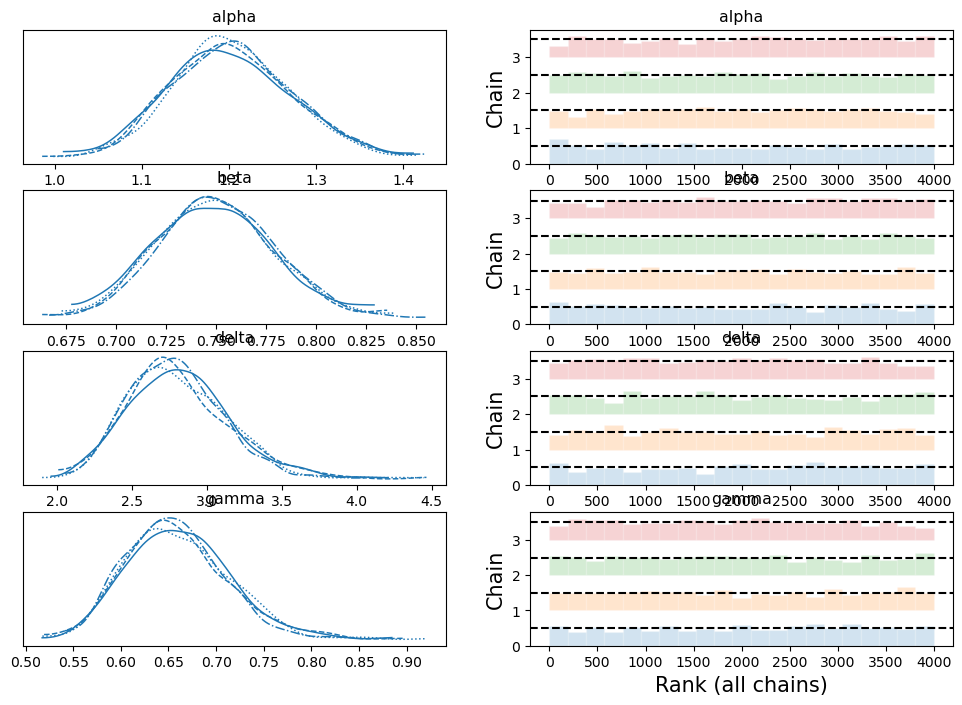

In [48]:
# w/ m=2 for pm.Pareto()
axes = az.plot_trace(
    data=idata_pool,
    var_names=["alpha","beta","delta","gamma"],
    compact=True,
    kind="rank_bars",
)

NameError: name 'plt' is not defined

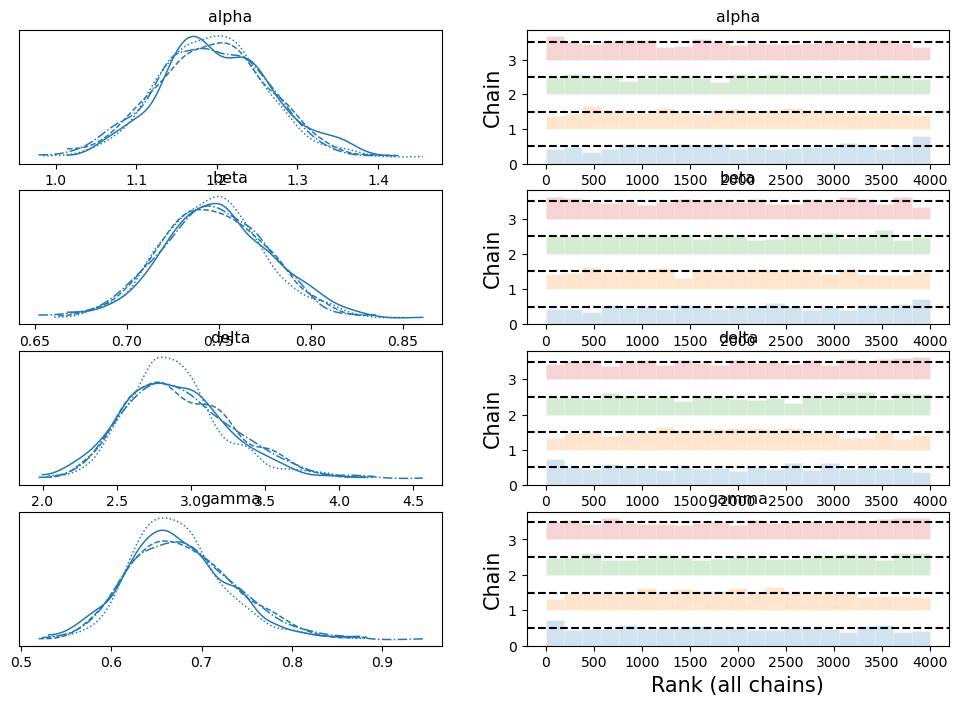

In [27]:
axes = az.plot_trace(
    data=idata,
    var_names=["alpha","beta","delta","gamma"],
    compact=True,
    kind="rank_bars",
)
plt.gcf().suptitle("BG/BB Model Trace", fontsize=18, fontweight="bold");

In [29]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.195,0.068,1.064,1.321,0.002,0.001,1215.0,1289.0,1.0
beta,0.748,0.029,0.692,0.801,0.001,0.001,1318.0,1466.0,1.0
delta,2.916,0.358,2.258,3.579,0.011,0.008,1045.0,1373.0,1.0
gamma,0.677,0.056,0.576,0.784,0.002,0.001,1103.0,1380.0,1.0


In [30]:
az.summary(idata_pool)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.203,0.068,1.081,1.333,0.002,0.001,1294.0,1742.0,1.0
beta,0.749,0.029,0.696,0.803,0.001,0.000,1895.0,2542.0,1.0
delta,2.806,0.321,2.235,3.417,0.009,0.006,1227.0,1630.0,1.0
gamma,0.659,0.050,0.565,0.753,0.001,0.001,1475.0,2171.0,1.0
kappa_dropout,3.465,0.370,2.795,4.162,0.010,0.007,1251.0,1673.0,1.0
kappa_purchase,1.953,0.095,1.787,2.137,0.003,0.002,1396.0,1906.0,1.0
phi_dropout,0.191,0.007,0.179,0.204,0.000,0.000,1143.0,1574.0,1.0
phi_purchase,0.616,0.007,0.603,0.629,0.000,0.000,1337.0,2127.0,1.0


In [31]:
bgbb._unload_params('alpha','beta','delta','gamma')

[1.2035223936080617, 0.7497163581757723, 2.78344198288741, 0.6567181695499195]